In [ ]:
!pip install cma

# Import

In [15]:
# --- Jupyter setup ---
%load_ext autoreload
%autoreload 2

# --- System path setup ---
import os
import sys
sys.path.append(os.getcwd())

# Verify the current directory
print("Current directory:", os.getcwd())

# --- Environment settings ---
nrn_options = "-nogui -NSTACK 100000 -NFRAME 20000"
os.environ["NEURON_MODULE_OPTIONS"] = nrn_options

# --- Core Python libraries ---
import math
import time
import warnings
from dataclasses import dataclass
from functools import partial

# --- NumPy & Matplotlib ---
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

# --- Skopt (Bayesian optimization) ---
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_gaussian_process, plot_convergence

# --- PyTorch & GPyTorch ---
import torch
from torch import nn
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

# --- BoTorch ---
from botorch import manual_seed
from botorch.acquisition import LogExpectedImprovement, qExpectedImprovement, qLogExpectedImprovement
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.models.gp_regression import SingleTaskGP as STGP
from botorch.models.kernels import InfiniteWidthBNNKernel
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.optim.optimize import optimize_acqf as optimize_acqf_fn
from botorch.test_functions import Ackley
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize

# --- Brian2 ---
from brian2 import *

# --- Custom Utilities ---
from utils.sim_utils import set_params_utils, eqs_utils, plotting_utils, obj_func_utils, set_param_space
from utils.methods_utils import ibnn_utils, shared_utils, turbo_utils, baseline_bo_utils, cma_utils
from utils.training_utils import prep_for_training

# --- Warning filters ---
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation


# Set up simulation environment

## initial simulation

Current directory: /Users/dusiyi/Downloads/Pulkit_class/final_project/selective_stimulation
Starting simulation at t=0. s for a duration of 6.1 s
2.8476 s (46%) simulated in 10s, estimated 11s remaining.
5.5261 s (90%) simulated in 20s, estimated 2s remaining.
6.1 s (100%) simulated in 21s


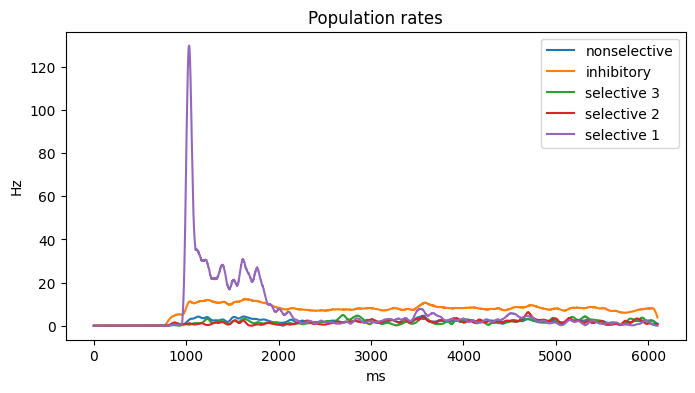

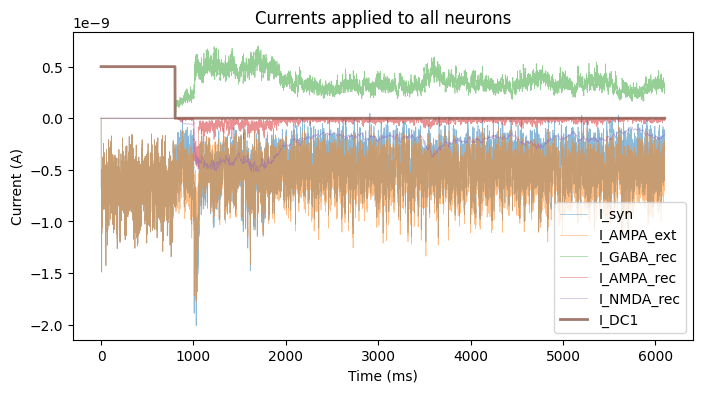

In [7]:
from utils.training_utils.set_train_env import*

In [8]:
pls_stop

NameError: name 'pls_stop' is not defined

# CMA

In [ ]:
import cma
x0 = [0.1, 0.7, 0.3, 0.7]
sigma = 0.3

means = []
sigmas = []
all_params = []
all_values = []
best_params_over_time = []
best_values_over_time = []

es = cma.CMAEvolutionStrategy(x0, sigma, {'popsize': 8, 
                                          'maxiter': 300,
                                          'bounds': [[0] * len(x0), [1] * len(x0)],
                                          })
iteration = 0
iteration += 1
while not es.stop():
    solutions = es.ask()
    fitnesses = [objective_with_factor(x) for x in solutions]
    es.tell(solutions, fitnesses)

    # Track values
    means.append(es.mean.copy())
    sigmas.append(es.sigma)
    all_params.extend(solutions)
    all_values.extend(fitnesses)
    best_params_over_time.append(min(fitnesses))
    best_values_over_time.append(solutions[np.argmin(fitnesses)])
    
    print(f"Iteration {iteration} | Best so far: {es.best.f}")


In [ ]:
print("Iterations completed:", es.countiter)
print("Function evaluations so far:", es.countevals)
print("Current mean:", es.mean)
print("Current sigma:", es.sigma)
print("Best solution so far:", es.best)
print("Best parameters found:", es.best.x)
print("Best objective value:", es.best.f)
print("Found at eval:", es.best.evals)
print("Stop criteria:", es.stop())


Iterations completed: 87
Function evaluations so far: 696


In [ ]:
import pickle
# The resulting bytes string-object can be saved to a file like:
filename = 'es-pickle-test'
open(filename, 'wb').write(es.pickle_dumps())
# # and recovered like:
# es = pickle.load(open(filename, 'rb'))
# # continue optimizing
# es.optimize(cma.ff.elli, iterations=22)  

## save results

## resume

In [ ]:
# import cma
# es = cma.CMAEvolutionStrategy().load('checkpoint/cmaes_restart.pkl')

In [ ]:
# while not es.stop():
#     X = es.ask()
#     Y = [objective(x) for x in X]
#     es.tell(X, Y)

## parse log

In [ ]:
from utils.methods_utils import cma_utils

pop_size = 8

with open("cma_output_log.txt", "r") as file:
    log_text = file.read()
all_params, all_normalized_value, df = cma_utils.parse_cma_log(log_text)
# df.to_csv("parsed_cma_results.csv", index=False)

updated_x = torch.tensor(all_params)
updated_y = - torch.tensor(all_normalized_value).reshape([-1, 1])

# shared_utils.save_results(updated_x, updated_y, result_dir='all_stored_results/cma_results')

top_y_over_iter, top_params_over_iter, top_index_over_iter = cma_utils.separate_cma_results_by_pop(updated_x, updated_y, pop_size)


# Eval

## retrieve results

In [ ]:
pop_size = 8
result_dir = 'all_stored_results/cma_results'
updated_x, updated_y = shared_utils.get_latest_results(result_dir)
#shared_utils.plot_best_results(updated_x, updated_y, objective_func_tensor)
top_y_over_iter, top_params_over_iter, top_index_over_iter = cma_utils.separate_cma_results_by_pop(updated_x, updated_y, pop_size)

## plot best objective value over time

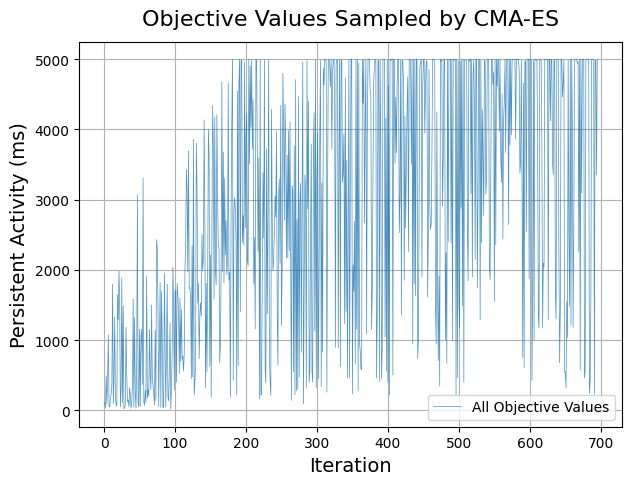

In [29]:
# suppress scientific notation
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

unnorm_factor = 5000

plt.figure(figsize=(7, 5))
plt.plot(updated_y * unnorm_factor, label='All Objective Values', alpha=0.8, linewidth=0.5)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Persistent Activity (ms)", fontsize=14)
plt.title("Objective Values Sampled by CMA-ES", fontsize=16, pad=12)


plt.grid(True)
plt.legend()
plt.show()


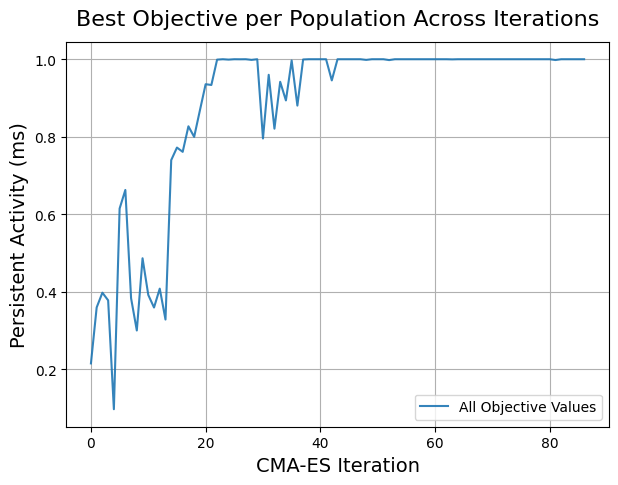

In [30]:
# Plot objective value over time
plt.figure(figsize=(7, 5))
plt.plot(top_y_over_iter, label='All Objective Values', alpha=0.9)


plt.xlabel("CMA-ES Iteration", fontsize=14)
plt.ylabel("Persistent Activity (ms)", fontsize=14)
plt.title("Best Objective per Population Across Iterations", fontsize=16, pad=12)
#plt.yscale("log")  # Use log scale if values span orders of magnitude
plt.grid(True)
plt.legend()
plt.show()


## plot best population value 

In [ ]:
# Plot best objective value over time
plt.figure()
plt.plot(top_y_over_iter, label='Best Objective So Far')
plt.xlabel("Iteration (Per Population)")
plt.ylabel("Objective Value")
plt.title("CMA-ES Convergence")
#plt.yscale("log")  # Use log scale if values span orders of magnitude
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'top_y_over_iter' is not defined

<Figure size 640x480 with 0 Axes>

## Plot Mean and Sigma

In [ ]:
import numpy as np


# Plot each dimension of the mean over iterations
plt.figure()
for dim in range(means.shape[1]):
    plt.plot(means[:, dim], label=f"Dim {dim}")
plt.xlabel("Iteration")
plt.ylabel("Mean Value")
plt.title("Search Distribution Mean Evolution")
plt.grid(True)
plt.legend()
plt.show()

# Plot sigma
plt.figure()
plt.plot(sigmas)
plt.xlabel("Iteration")
plt.ylabel("Sigma (Step Size)")
plt.title("Step Size Evolution")
plt.grid(True)
plt.show()
